# Speedrunning Under the Eyes Of Machine Learning

This notebook is purely for the presentation of the work in this final project. It details the results of the other notebooks in a shorter, more digestable format.

### Table of Contents

 1. Exploratory Analysis
 2. Network Centrality Analysis
 3. Community Detection and Evaluation
 4. Recommendation Systems

In [2]:
# %pip install networkx pandas numpy matplotlib scipy scikit-network sklearn

import csv
import collections
import requests

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from datetime import datetime
from operator import itemgetter
from functools import reduce
from scipy import sparse
from sknetwork.clustering import Louvain, get_modularity
from sklearn.model_selection import train_test_split


## Exploratory Analysis

### Games Analysis

In [4]:
FINAL_DATE = datetime(2023, 1, 1)

def generate_network_filter(filename: str, disallowed_games=None, allowed_games=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        filter_map = defaultdict(bool)
        for row in csv_reader:
            # Check if the created/release date is after 2023, if it is then we can ignore it in the network.
            release_date = datetime.strptime(row[3], "%Y-%m-%d")
            if row[4] == "None":
                row[4] = "2017-10-22T05:21:29Z" # This is a completely random date before the final date.
            created_date = datetime.strptime(row[4], "%Y-%m-%dT%H:%M:%SZ")

            if disallowed_games == None:
                disallowed_games = ["y65797de"]

            if allowed_games == None:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games:
                    filter_map[row[0]] = True
            else:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games and row[0] in allowed_games:
                    filter_map[row[0]] = True

    return filter_map

def get_weighted_edges_from_csv(filename, filter=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)

        edges = list()
        for row in csv_reader:
            if filter is None:
                edges.append(tuple([row[0], row[1], int(row[2])]))
                continue
            
            if not filter.get(row[0]) or not filter.get(row[1]):
                continue

            edges.append(tuple([row[0], row[1], int(row[2])]))

    return edges

def generate_graph_from_edges(edges_list):
    directed_graph = nx.DiGraph()
    directed_graph.add_weighted_edges_from(edges_list)
    return directed_graph

def save_weighted_graph(g: nx.DiGraph, filename: str):
    with open(filename, 'w', encoding='utf-8') as openfile:
        openfile.write("Source,Target,Weight\n")
        for source,target,data in g.edges(data=True):
            weight = int(data['weight'])
            output_string = ','.join(map(str, [source, target, weight]))
            openfile.write(f"{output_string}\n")

def get_centrality_from_file(filename: str) -> dict[str, float]:
    node_to_centrality = defaultdict(float)
    with open(filename, 'r', encoding='utf-8') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        for row in csv_reader:
            node_to_centrality[row[0]] = float(row[1])

    return node_to_centrality

In [5]:
def rename_columns(df: pd.DataFrame):
    return df.rename(columns={
        'game_num_categories': 'num_categories',
        'game_num_levels': 'num_levels',
        'game_num_runs': 'num_runs',
        'game_num_users': 'num_users',
        'game_num_guests': 'num_guests',
        'game_created_date': 'created_date',
        'game_release_date': 'release_date',
        'game_developers': 'developers',
    })

def format_games_metadata_dataframe(df: pd.DataFrame):
    df = rename_columns(df)
    # Remove row if game do not have a created date.
    df.drop(df[df['created_date'] == 'None'].index, inplace=True)
    
    # Remove rows with N/As in them.
    df = df.dropna()
    
    # Format the release_date and created_date to be an actual date type.
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['created_date'] = pd.to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['release_date'] = pd.to_datetime(df['release_date'].dt.strftime('%Y-%m-%d'))
    df['created_date'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%m-%d'))
    
    # Remove rows with a created date or release date before cutoff.
    df = df[(df['created_date'] < '2023-01-01') & (df['release_date'] < '2023-01-01')] 
    
    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
    
    # Rename the game_id column to just id.
    df.rename(columns = {'game_id' : 'id'}, inplace=True)

    return df

In [6]:
def game_game_graph_degree_plots(graph: nx.Graph):
    in_degrees_with_weight = [d for n, d in graph.in_degree(weight='weight')]
    out_degrees_with_weight = [d for n, d in graph.out_degree(weight='weight')]
    in_degree_with_weights_counts = sorted(collections.Counter(in_degrees_with_weight).items(), key=itemgetter(1), reverse=True)
    out_degree_with_weights_counts = sorted(collections.Counter(out_degrees_with_weight).items(), key=itemgetter(1), reverse=True)
    fig, ax = plt.subplots(1, 2)
    x, y = list(zip(*in_degree_with_weights_counts))
    ax[0].loglog(x, y, 'bo-')
    ax[0].set_ylabel("# of Nodes")
    ax[0].set_xlabel("In Degree With Weight")

    x, y = list(zip(*out_degree_with_weights_counts))
    ax[1].loglog(x, y, 'ko-')
    ax[1].set_ylabel("# of Nodes")
    ax[1].set_xlabel("Out Degree With Weight")

    fig.set_figheight(10)
    fig.set_figwidth(20)
    return fig, ax

In [7]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['game_num_categories', 'game_num_levels', 'game_num_runs', 'game_num_users', 'game_num_guests']] = games_metadata_df[['game_num_categories', 'game_num_levels', 'game_num_runs', 'game_num_users', 'game_num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)
formatted_games_metadata_df = format_games_metadata_dataframe(games_metadata_df.copy())
formatted_games_metadata_df.describe(include='all', datetime_is_numeric=True)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
count,31405,31405,31405,31405,31405,31405.000000,31405.000000,31405.000000,31405.000000,31405.000000
unique,31397,31376,8269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ldejp051,Dreams,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,3,17962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2009-12-04 13:57:32.583983616,2019-05-15 20:41:21.999681536,3.943894,7.026652,87.790288,19.164241,1.862793
min,NaN,NaN,NaN,1972-01-01 00:00:00,2014-11-30 00:00:00,0.000000,0.000000,0.000000,-999.000000,-999.000000
25%,NaN,NaN,NaN,2002-08-12 00:00:00,2017-03-20 00:00:00,2.000000,0.000000,3.000000,2.000000,0.000000
50%,NaN,NaN,NaN,2012-11-13 00:00:00,2019-09-07 00:00:00,3.000000,0.000000,10.000000,4.000000,0.000000
75%,NaN,NaN,NaN,2018-10-16 00:00:00,2021-08-15 00:00:00,5.000000,5.000000,37.000000,10.000000,0.000000
max,NaN,NaN,NaN,2022-12-25 00:00:00,2022-12-31 00:00:00,183.000000,2042.000000,61962.000000,7168.000000,15646.000000


In [8]:
n = 519
print(f"The top {n} games have {sum(formatted_games_metadata_df.sort_values(by='num_runs', ascending=False)['num_runs'][:n])} runs, and the bottom {formatted_games_metadata_df.count()['id'] - n} has {sum(formatted_games_metadata_df.sort_values(by='num_runs', ascending=False)['num_runs'][n:])} runs.")
print(f"Difference between number of runs of top {n} games and 50% of all runs: {sum(formatted_games_metadata_df.sort_values(by='num_runs', ascending=False)['num_runs'][:n]) - (formatted_games_metadata_df['num_runs'].sum() // 2)}")
print(f"{(formatted_games_metadata_df.count()['id'] - n)/formatted_games_metadata_df.count()['id'] * 100:.2f}% of games have the same number of runs as the top {n/formatted_games_metadata_df.count()['id'] * 100:.2f}% of games")

The top 519 games have 1378482 runs, and the bottom 30886 has 1378572 runs.
Difference between number of runs of top 519 games and 50% of all runs: -45
98.35% of games have the same number of runs as the top 1.65% of games


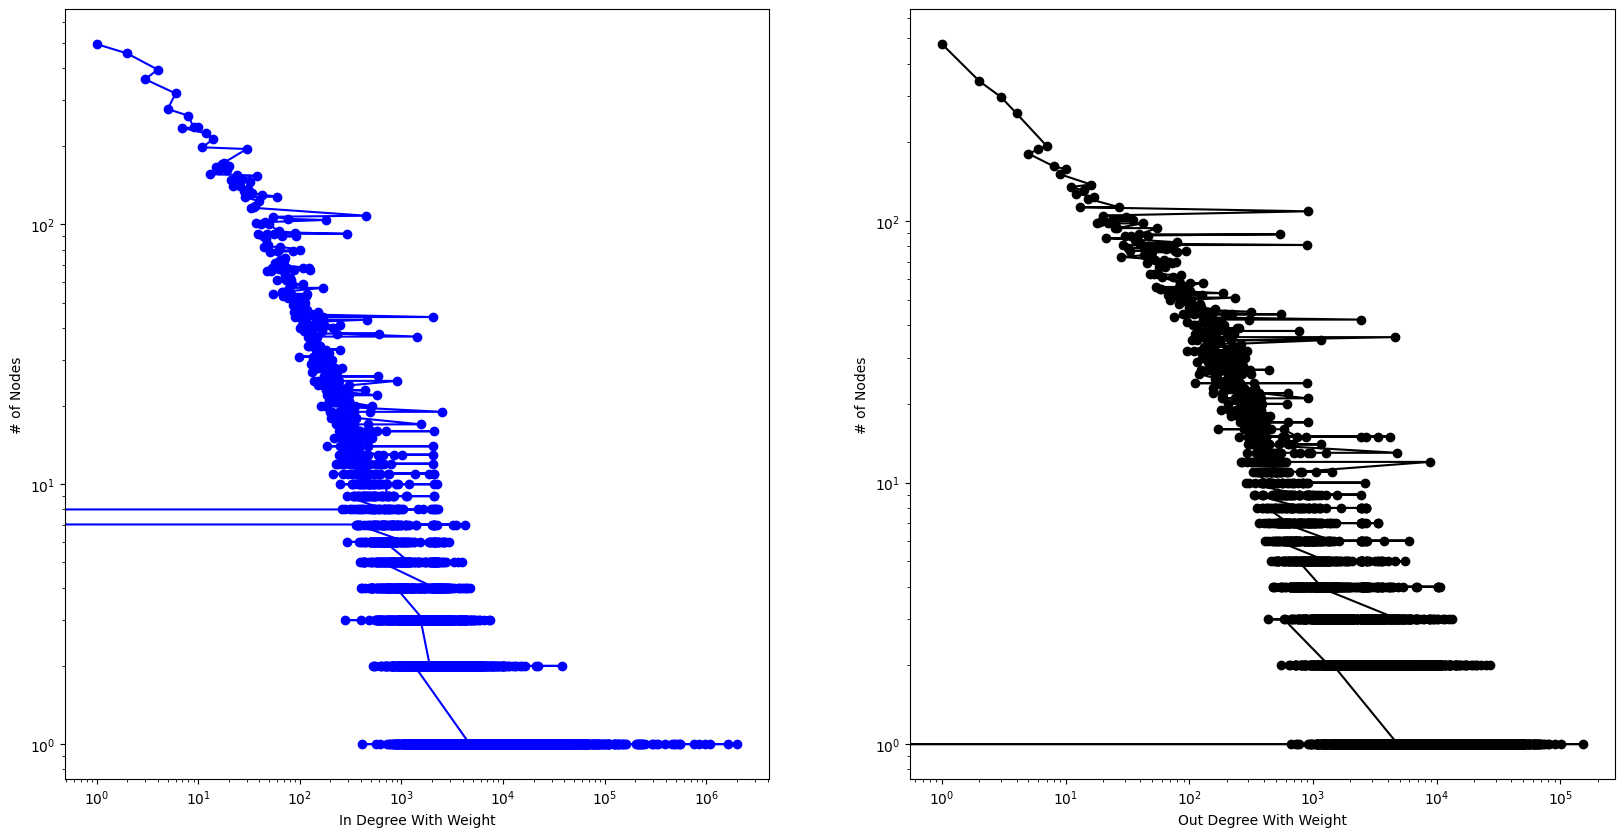

In [13]:
graph_filename = "../data/too_big/all_games_filtered.csv"
edges = get_weighted_edges_from_csv(graph_filename, filter=None)
filtered_graph = generate_graph_from_edges(edges)
fig, ax = game_game_graph_degree_plots(filtered_graph)
plt.show()

In [14]:
weak_components = sorted([component for component in nx.weakly_connected_components(filtered_graph)], key=len, reverse=True)
strong_components = sorted([component for component in nx.strongly_connected_components(filtered_graph)], key=len, reverse=True)

largest_weak_component = len(max(weak_components, key=len))
largest_strong_component = len(max(strong_components, key=len))

print(f"Largest weak component: {largest_weak_component}\nLargest strong component: {largest_strong_component}")

Largest weak component: 30344
Largest strong component: 30335


### User Analysis

In [3]:
def format_user_prefs_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()[(df['user_signup_date'].notna()) &(df['user_signup_date'] != "Null")]
    df['user_signup_date'] = pd.to_datetime(df['user_signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['user_signup_date'] = pd.to_datetime(df['user_signup_date'].dt.strftime('%Y-%m-%d'))
    df = df[(df['user_signup_date'] < '2023-01-01')]
    return df

In [5]:
user_prefs_df = pd.read_csv("../data/raw/srcom_users_with_metadata.csv")
user_prefs_df = format_user_prefs_df(user_prefs_df)
user_prefs_df.describe(include='all')

,user_id,user_signup_date,user_location,user_num_games,user_games
count,335322,335322,277215,335322.000000,335322
unique,335322,NaN,256,NaN,88806
top,j5wzz2qj,NaN,us,NaN,k6q4rqzd
freq,1,NaN,101439,NaN,5131
mean,NaN,2020-06-28 13:40:53.271780608,NaN,1.994465,NaN
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN
25%,NaN,2019-09-16 00:00:00,NaN,1.000000,NaN
50%,NaN,2021-01-04 00:00:00,NaN,1.000000,NaN
75%,NaN,2021-09-25 00:00:00,NaN,2.000000,NaN
max,NaN,2022-12-31 00:00:00,NaN,2059.000000,NaN


In [6]:
user_runs_df = pd.read_csv('../data/raw/srcom_user_runs.csv')
user_runs_df = user_runs_df[(user_runs_df['user_num_runs'] != 0)]
user_runs_df.describe(include='all')

,user_id,user_num_runs
count,332897,332897.000000
unique,332897,NaN
top,0jm002y8,NaN
freq,1,NaN
mean,NaN,9.274109
std,NaN,57.344546
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,2.000000
75%,NaN,5.000000


In [7]:
merged_df = pd.merge(user_runs_df, user_prefs_df, on='user_id')
merged_df['user_num_runs_zscore'] = (merged_df['user_num_runs'] - merged_df['user_num_runs'].mean()) / merged_df['user_num_runs'].std()
merged_df['user_num_games_zscore'] = (merged_df['user_num_games'] - merged_df['user_num_games'].mean()) / merged_df['user_num_games'].std()
print(f"Number of runs: {merged_df['user_num_runs'].sum():,}")
print(f"Number of users: {merged_df['user_id'].count():,}")
print(f"Number of games: {merged_df['user_games'].str.split(',').explode().nunique():,}")

Number of runs: 3,086,954
Number of users: 332,746
Number of games: 31,416


In [8]:
print(f"Number of users with 1 run: {merged_df[(merged_df['user_num_runs'] == 1)]['user_num_runs'].count():,}")
print(f"Number of users that played 1 game: {merged_df[(merged_df['user_num_games'] == 1)]['user_num_runs'].count():,}")
print(f"Mean number of runs for users that played 1 game: {merged_df[(merged_df['user_num_games'] == 1)]['user_num_runs'].mean():.3f}")
print(f"Median number of runs for users that played 1 game: {merged_df[(merged_df['user_num_games'] == 1)]['user_num_runs'].median():.3f}")

Number of users with 1 run: 138,183
Number of users that played 1 game: 244,598
Mean number of runs for users that played 1 game: 2.736
Median number of runs for users that played 1 game: 1.000


In [13]:
def add_country_locations(df: pd.DataFrame, country_location_filename: str) -> pd.DataFrame:
    country_df = pd.read_csv(country_location_filename)
    country_df = country_df[['Country', 'Alpha-2 code']].rename(
        columns={'Alpha-2 code': 'user_location', 'Country': 'user_country'})
    country_df['user_location'] = country_df['user_location'].str.strip()
    country_df['user_location'] = country_df['user_location'].str.replace(
        '\"', '', -1)
    merged_df = country_df.merge(df, on='user_location', how='right')
    merged_df = merged_df[merged_df.user_country != "Russian Federation"]
    return merged_df


def combine_similar_countries(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[df['user_location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'user_location'] = 'GB'
    df.loc[df['user_location'].isin(['CA', 'CA/QC']), 'user_location'] = 'CA'
    df.loc[df['user_location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'user_location'] = 'ES'
    return df.groupby(['user_location']).sum(numeric_only=True).reset_index(inplace=False)


def create_user_country_df(df: pd.DataFrame) -> pd.DataFrame:
    grouped_df = df.groupby(['user_location'])
    grouped_sum_df = grouped_df.sum(numeric_only=True)
    grouped_sum_df['number'] = grouped_df.count().iloc[:, 0]
    grouped_sum_df.reset_index(inplace=True)
    grouped_sum_df['user_location'] = grouped_sum_df['user_location'].str.upper()
    return grouped_sum_df

In [14]:
user_country_df = create_user_country_df(user_prefs_df)
user_country_df = combine_similar_countries(user_country_df)
user_country_df = add_country_locations(user_country_df, "../data/processed/users/countries_codes_and_coordinates.csv")
user_country_df['percentage'] = round(user_country_df['number'] / user_country_df['number'].sum() * 100, 2)
user_country_df.sort_values(by='number', ascending=False).head(15)

,user_country,user_location,user_num_games,number,percentage
238,United States,US,231617,101439,29.96
172,NaN,NONE,75708,58107,17.16
81,United Kingdom,GB,41008,20030,5.92
39,Canada,CA,41427,17135,5.06
79,France,FR,25789,12425,3.67
59,Germany,DE,24277,11794,3.48
12,Australia,AU,18675,9765,2.88
32,Brazil,BR,18609,8987,2.65
197,Russia,RU,15221,7534,2.23
184,Poland,PL,11667,5955,1.76


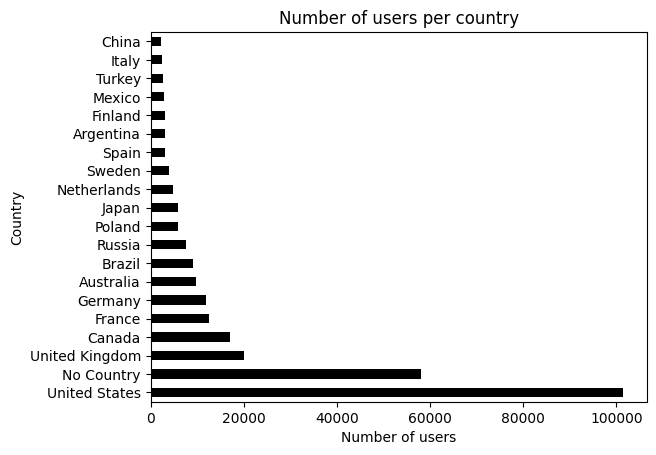

In [48]:
num_countries = 20
tmp_df = user_country_df.sort_values(by='number', ascending=False).head(num_countries)
tmp_df['user_country'].iloc[1] = "No Country"
ax = tmp_df.plot.barh(x='user_country', y='number', color='black')
ax.get_legend().remove()
ax.set_xlabel('Number of users')
ax.set_ylabel('Country')
ax.set_title('Number of users per country')
plt.show()

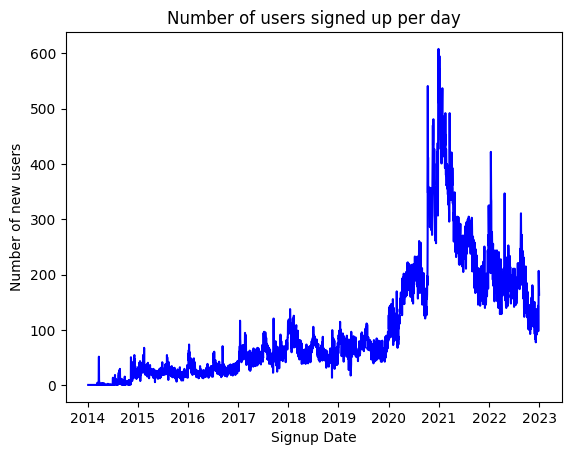

In [49]:
fig, ax = plt.subplots(1, 1)
df = user_prefs_df.copy().groupby(['user_signup_date']).count().reset_index()
ax.plot(df['user_signup_date'], df['user_id'], color='blue')
ax.set_xlabel("Signup Date")
ax.set_ylabel("Number of new users")
ax.set_title("Number of users signed up per day")
plt.show()

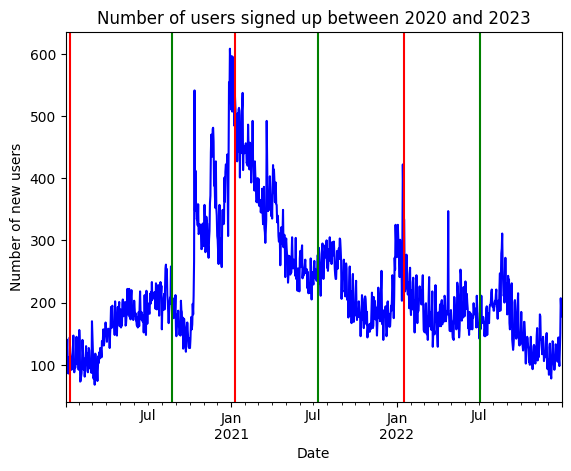

In [50]:
user_signup_2020_2023_df = df[(df['user_signup_date'] > '2020-01-01') & (df['user_signup_date'] < '2022-12-31')]

ax = user_signup_2020_2023_df.sort_values(by='user_signup_date').plot.line(x='user_signup_date', y='user_id', color='blue')

ax.axvline('2020-01-12', color='red')
ax.axvline('2021-01-10', color='red')
ax.axvline('2022-01-16', color='red')

ax.axvline('2020-08-23', color='green')
ax.axvline('2021-07-11', color='green')
ax.axvline('2022-07-03', color='green')

ax.get_legend().remove()
ax.set_xlabel("Date")
ax.set_ylabel("Number of new users")
ax.set_title("Number of users signed up between 2020 and 2023")
plt.show()


Cutoff: 31.63723117216306


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


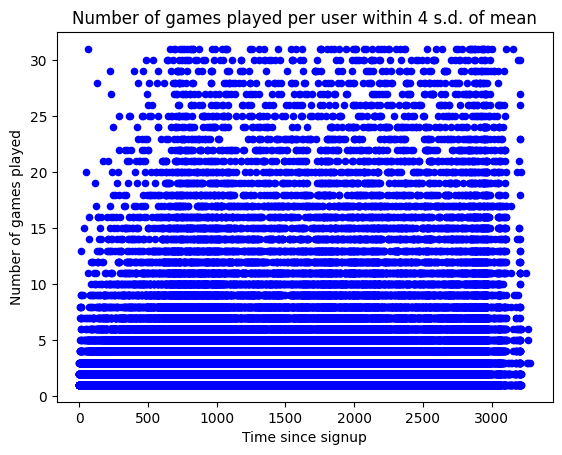

In [51]:
user_type_df = user_prefs_df.copy()
user_type_df['time_registered'] = (datetime(2023, 1, 1) - user_type_df['user_signup_date']) / np.timedelta64(1, 'D')
mean = user_type_df['user_num_games'].mean()
sd = user_type_df['user_num_games'].std()
n_std = 4
print(f"Cutoff: {mean+(n_std*sd)}")
ax = user_type_df[(user_type_df['user_num_games'] <= mean+(n_std*sd))].plot.scatter(x='time_registered', y='user_num_games', c='blue')
ax.set_ylabel("Number of games played")
ax.set_xlabel("Time since signup")
ax.set_title("Number of games played per user within 4 s.d. of mean")
plt.show()

Number of users that have played one game: 246995


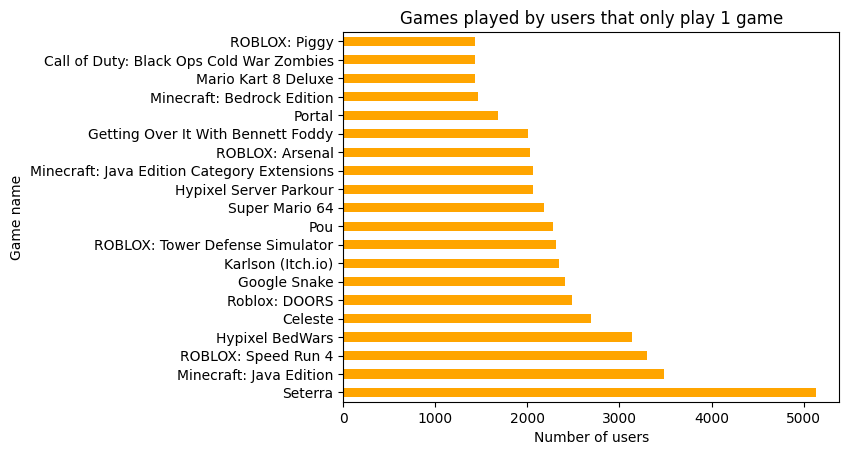

In [54]:
one_game_user_df = user_prefs_df[(user_prefs_df['user_num_games'] == 1)].rename(columns={'user_games': 'id'})
games_metadata_df = pd.read_csv("../data/raw/srcom_games_with_metadata.csv").rename(columns={'game_id': 'id'})
one_game_user_df = one_game_user_df.groupby('id').count().reset_index()
merged_df = one_game_user_df.merge(games_metadata_df, on='id', how='inner')
number_of_values = 20
merged_df = merged_df[['game_name', 'user_num_games']].sort_values(by='user_num_games').tail(number_of_values).iloc[::-1]
print(f"Number of users that have played one game: {user_prefs_df[(user_prefs_df['user_num_games'] == 1)].rename(columns={'user_games': 'id'}).count()['user_id']}")
ax = merged_df.plot.barh(x='game_name', y='user_num_games', color='orange')
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Games played by users that only play 1 game")
ax.get_legend().remove()
plt.show()

Number of users that have played two games: 43367


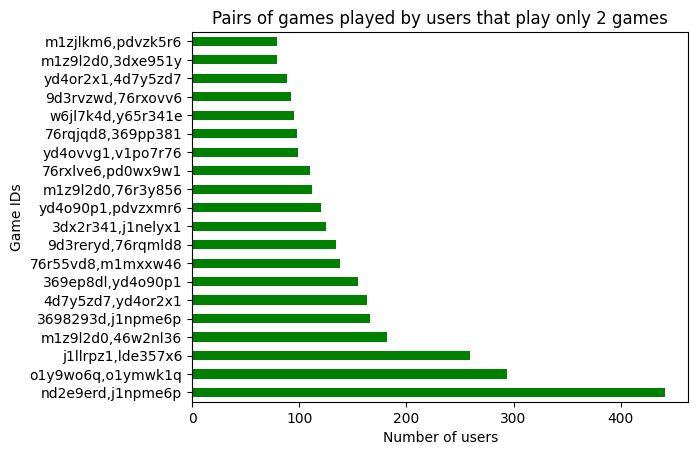

In [55]:
two_game_user_df = user_prefs_df[(user_prefs_df['user_num_games'] == 2)].rename(columns={'user_games': 'id'})
two_game_user_df = two_game_user_df.groupby('id').count().reset_index()
two_game_user_df = two_game_user_df[['id', 'user_num_games']].sort_values(by='user_num_games').tail(number_of_values).iloc[::-1]
print(f"Number of users that have played two games: {user_prefs_df[(user_prefs_df['user_num_games'] == 2)].rename(columns={'user_games': 'id'}).count()['user_id']}")
ax = two_game_user_df.plot.barh(x='id', y='user_num_games', color='green')
ax.set_xlabel("Number of users")
ax.set_ylabel("Game IDs")
ax.get_legend().remove()
ax.set_title("Pairs of games played by users that play only 2 games")
plt.show()

## Network Centrality Analysis

In [16]:
hits_centrality_filename = "../data/processed/games/centrality/all_games_hits_centrality.csv"
pagerank_filename = "../data/processed/games/centrality/all_games_pagerank.csv"
betweenness_centrality_filename = "../data/processed/games/centrality/all_games_betweenness_centrality.csv"

hits_centrality_df = pd.read_csv(hits_centrality_filename)
pagerank_df = pd.read_csv(pagerank_filename).rename(columns={'value': 'pagerank_value'})
betweenness_centrality_df = pd.read_csv(betweenness_centrality_filename).rename(columns={'value': 'betweenness_value'})

games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df = rename_columns(games_metadata_df)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df = format_games_metadata_dataframe(games_metadata_df)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

all_dataframes = [games_metadata_df, hits_centrality_df, pagerank_df, betweenness_centrality_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='id'), all_dataframes)
merged_df.describe(datetime_is_numeric=True, include='all')

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,authority_value,hub_value,pagerank_value,betweenness_value
count,29661,29661,29661,29661,29661,29661.000000,29661.000000,29661.000000,29661.000000,29661.000000,2.966100e+04,2.966100e+04,29661.000000,2.966100e+04
unique,29654,29635,7788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ldejp051,Dreams,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,3,16920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2009-10-14 02:08:50.878931968,2019-04-20 00:02:31.471629312,4.013654,7.292809,91.483531,20.274367,1.993763,3.504879e-04,1.382893e-03,0.000032,4.907409e-05
min,NaN,NaN,NaN,1972-01-01 00:00:00,2014-11-30 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000005,0.000000e+00
25%,NaN,NaN,NaN,2002-04-25 00:00:00,2017-02-19 00:00:00,2.000000,0.000000,4.000000,2.000000,0.000000,5.189719e-07,1.664833e-07,0.000007,4.983197e-08
50%,NaN,NaN,NaN,2012-09-20 00:00:00,2019-07-28 00:00:00,3.000000,0.000000,12.000000,4.000000,0.000000,3.945373e-06,1.810139e-06,0.000010,2.965493e-06
75%,NaN,NaN,NaN,2018-09-05 00:00:00,2021-07-20 00:00:00,5.000000,5.000000,41.000000,11.000000,0.000000,3.625000e-05,9.826902e-05,0.000024,2.972893e-05
max,NaN,NaN,NaN,2022-12-25 00:00:00,2022-12-31 00:00:00,183.000000,2042.000000,61962.000000,7168.000000,15646.000000,5.935696e-01,1.288346e-01,0.021878,1.385887e-02


In [23]:
tmp_df = merged_df.groupby(['developers'])
grouped_merged_df = tmp_df.sum(numeric_only=True)
grouped_merged_df['num_games_per_developer'] = tmp_df.count().iloc[:, 0]
del tmp_df

In [24]:
merged_df.sort_values(by="hub_value", ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,authority_value,hub_value,pagerank_value,betweenness_value
25466,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13,9,333,3103,31,0,0.164470,0.128835,0.005509,0.000090
28194,9do8lpk1,Maze (Coolmath Games),None,2022-01-01,2022-07-19,4,200,2133,55,0,0.078550,0.095686,0.002526,0.000022
22673,m1mnnojd,Factris,None,2018-12-09,2021-06-04,3,0,145,46,1,0.005934,0.091759,0.000248,0.000153
20836,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19,11,32,17105,4236,8,0.027298,0.088676,0.001578,0.003797
18517,4d790zr1,Tomb of the Mask,pe13wyzo,2016-02-19,2018-05-27,7,100,703,206,0,0.008909,0.086131,0.000412,0.000772
19543,j1n07edp,Super Cat Bros.,ne4k096m,2016-11-17,2017-07-31,5,54,615,64,1,0.018702,0.083844,0.000773,0.000121
17766,nd283med,Brain It On!,None,2015-06-25,2022-07-05,3,200,667,40,0,0.010973,0.082741,0.000451,0.000094
22392,369pxvg1,Google Minesweeper,None,2018-10-10,2020-07-11,2,0,3572,1696,0,0.003115,0.081525,0.000192,0.002198
4715,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27,29,903,61962,7168,36,0.593570,0.081210,0.021878,0.006154
12175,k6q474zd,Minecraft (Classic),None,2009-05-17,2020-09-15,11,0,4563,2599,14,0.008157,0.077946,0.000603,0.005431


In [25]:
merged_df.sort_values(by="authority_value", ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,authority_value,hub_value,pagerank_value,betweenness_value
4715,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27,29,903,61962,7168,36,0.593570,0.081210,0.021878,6.153765e-03
17372,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13,13,30,4844,43,0,0.445458,0.068188,0.015118,6.654527e-05
12600,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13,20,274,2897,95,2,0.271052,0.018274,0.006820,1.587748e-04
25023,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12,10,550,3478,24,1,0.270346,0.074065,0.006812,9.026303e-05
13261,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03,16,999,3354,71,1,0.236636,0.042675,0.007070,6.963308e-05
25466,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13,9,333,3103,31,0,0.164470,0.128835,0.005509,9.046502e-05
14839,m1zjnrm6,Hill Climb Racing,v6dynp62,2012-09-22,2018-07-02,13,0,4253,180,2,0.152589,0.073545,0.004682,7.719114e-05
23879,9dowpxm1,Gravity Box,None,2019-09-28,2019-10-08,3,268,2197,33,0,0.142831,0.061883,0.004469,5.445706e-06
16806,o1y7pv1q,White Tiles 4: Piano Master 2,3zym21z4,2014-10-03,2016-03-31,128,0,4829,225,7,0.127075,0.054620,0.005240,5.175375e-04
23702,9do84qm1,Infinite Arrow,None,2019-08-26,2022-01-09,8,200,1564,21,0,0.126786,0.072173,0.004008,4.391604e-09


In [26]:
merged_df.sort_values(by="pagerank_value", ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,authority_value,hub_value,pagerank_value,betweenness_value
4715,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27,29,903,61962,7168,36,0.593570,0.081210,0.021878,0.006154
17372,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13,13,30,4844,43,0,0.445458,0.068188,0.015118,0.000067
16776,w6jl9o5d,Final Fantasy Record Keeper,leqowy6w,2014-09-24,2018-04-02,15,645,1733,10,0,0.007365,0.000073,0.008205,0.000003
13261,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03,16,999,3354,71,1,0.236636,0.042675,0.007070,0.000070
12600,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13,20,274,2897,95,2,0.271052,0.018274,0.006820,0.000159
25023,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12,10,550,3478,24,1,0.270346,0.074065,0.006812,0.000090
25466,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13,9,333,3103,31,0,0.164470,0.128835,0.005509,0.000090
16806,o1y7pv1q,White Tiles 4: Piano Master 2,3zym21z4,2014-10-03,2016-03-31,128,0,4829,225,7,0.127075,0.054620,0.005240,0.000518
14839,m1zjnrm6,Hill Climb Racing,v6dynp62,2012-09-22,2018-07-02,13,0,4253,180,2,0.152589,0.073545,0.004682,0.000077
23879,9dowpxm1,Gravity Box,None,2019-09-28,2019-10-08,3,268,2197,33,0,0.142831,0.061883,0.004469,0.000005


In [27]:
merged_df.sort_values(by="betweenness_value", ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,authority_value,hub_value,pagerank_value,betweenness_value
21334,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15,15,9,32317,5406,14,0.003446,0.026889,0.001419,0.013859
18057,nd22xvd0,Refunct,ge0ry3ep,2015-10-16,2015-10-20,4,0,5669,1568,6,0.001111,0.008059,0.000353,0.010138
20956,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27,6,0,17212,3790,45,0.003048,0.020218,0.000642,0.008230
10934,9d3rv59d,Bee Movie Game (DS),81e7o2z7,2007-10-30,2019-08-01,2,0,236,221,3,0.001944,0.056654,0.000172,0.007226
4715,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27,29,903,61962,7168,36,0.593570,0.081210,0.021878,0.006154
3076,268pjodp,Barney's Hide & Seek Game,None,1993-06-01,2015-02-08,4,0,365,267,18,0.000870,0.006128,0.000222,0.005630
27,k6qew96g,Dragster,nw631zx9,1980-01-01,2017-06-26,2,0,890,368,9,0.000838,0.008580,0.000160,0.005625
17762,nd2z5qd0,There Is No Game,1zk9xoej,2015-06-25,2015-07-06,9,3,4491,2422,20,0.003885,0.036353,0.000311,0.005568
20250,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30,10,0,15196,3046,20,0.007541,0.017284,0.001478,0.005520
20848,w6jmm26j,Cuphead,rzjkx7el,2017-09-29,2017-09-30,19,31,12221,1984,44,0.004627,0.004545,0.001566,0.005445


In [28]:
bc_df = grouped_merged_df.copy()
bc_df['average_betweenness'] = bc_df['betweenness_value'] / bc_df['num_games_per_developer']
bc_df[['average_betweenness', 'betweenness_value', 'num_games_per_developer']].sort_values(by="average_betweenness", ascending=False).head(10)

,average_betweenness,betweenness_value,num_games_per_developer
developers,,,
1zk4q26j,0.007265,0.014529,2
"4eppvoer,ne410dem",0.006154,0.006154,1
1e7do1e7,0.004234,0.004234,1
"xv6dvx62,p6xlqm61,5yz8gx6w,4rzj1zlk",0.004013,0.004013,1
4ep7k3er,0.003844,0.003844,1
pe1wp36o,0.003797,0.003797,1
ge0ry3ep,0.003402,0.010207,3
dv690v6x,0.003131,0.006262,2
"1zkdw96j,xv6dvx62,y4zw106k",0.003105,0.003105,1


In [9]:
developer = "1zk4q26j"
response = requests.get(f"https://speedrun.com/api/v1/developers/{developer}")
response_data = response.json().get("data")
print(f"ID: {response_data.get('id')}\nName: {response_data.get('name')}")

ID: 1zk4q26j
Name: Matt Makes Games Inc.


## Community Detection and Evaluation

###  Game-Game Graph

In [30]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df = rename_columns(games_metadata_df)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

In [31]:
louvain_communities_df = pd.read_csv("../data/processed/games/communities/all_games_louvain_communities.csv").rename(columns={'node_id': 'id'})
merged_df = games_metadata_df.merge(louvain_communities_df, on='id', how='inner')
merged_df = merged_df.groupby('community_num').count().sort_values(by='id').tail().iloc[::-1][['id']].rename(columns={'id':'num_games'}).reset_index()
merged_df['zscore'] = (merged_df['num_games'] -merged_df['num_games'].mean()) / merged_df['num_games'].std()
merged_df.sort_values(by='zscore', ascending=False).head(15)

,community_num,num_games,zscore
0,23,16380,1.786567
1,8,1924,-0.383481
2,16,1742,-0.410802
3,74,1207,-0.491113
4,38,1140,-0.501171


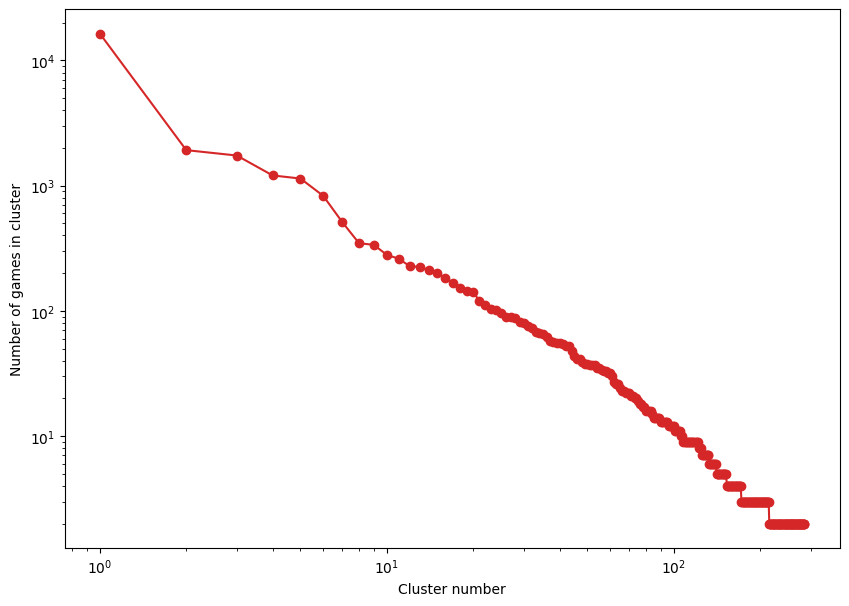

In [32]:
fig, ax = plt.subplots(1, 1)
_, counts = list(zip(*sorted(Counter(louvain_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
x = [i for i in range(1, len(counts)+1)]
ax.loglog(x, counts, color='tab:red', marker='o')
ax.set_xlabel("Cluster number")
ax.set_ylabel("Number of games in cluster")
fig.set_figwidth(10)
fig.set_figheight(7)
plt.show()

In [33]:
greedy_modularity_communities_df = pd.read_csv("../data/processed/games/communities/all_games_greedy_modularity_communities.csv").rename(columns={'node_id': 'id'})
merged_df = games_metadata_df.merge(greedy_modularity_communities_df, on='id', how='inner')
merged_df = merged_df.groupby('community_num').count().sort_values(by='id').tail(
).iloc[::-1][['id']].rename(columns={'id': 'num_games'}).reset_index()
merged_df['zscore'] = (merged_df['num_games'] - merged_df['num_games'].mean()) / merged_df['num_games'].std()
merged_df.sort_values(by='zscore', ascending=False).head(15)

,community_num,num_games,zscore
0,0,24070,1.758287
1,1,4653,-0.132806
2,2,1294,-0.459951
3,3,46,-0.581499
4,4,20,-0.584031


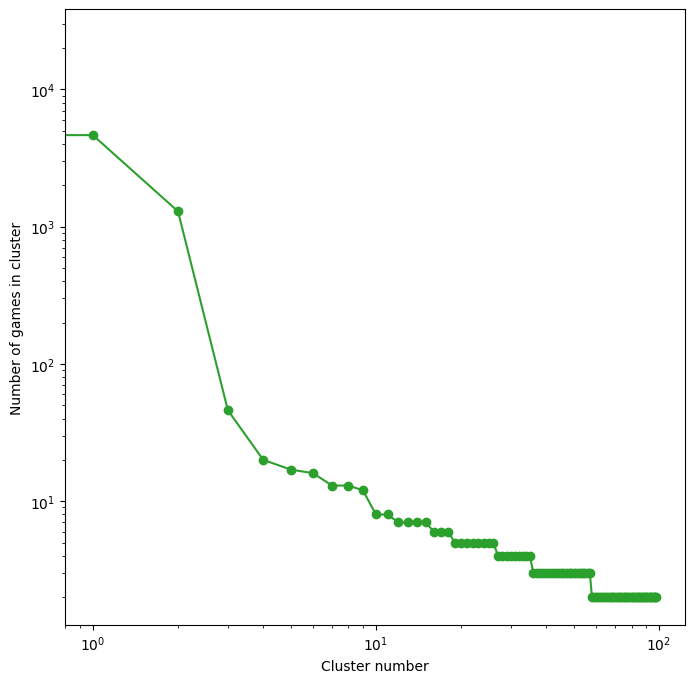

In [34]:
cluster_num, counts = list(zip(*sorted(Counter(greedy_modularity_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
fig, ax = plt.subplots(1, 1)
ax.loglog(cluster_num, counts, color='tab:green', marker='o')
ax.set_xlabel("Cluster number")
ax.set_ylabel("Number of games in cluster")
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [35]:
infomap_communities_df = pd.read_csv("../data/processed/games/communities/all_games_infomap_communities.csv").rename(columns={'node_id': 'id'})
merged_df = games_metadata_df.merge(infomap_communities_df, on='id', how='inner')
merged_df = merged_df.groupby('community_num').count().sort_values(by='id').tail(
).iloc[::-1][['id']].rename(columns={'id': 'num_games'}).reset_index()
merged_df['zscore'] = (merged_df['num_games'] - merged_df['num_games'].mean()) / merged_df['num_games'].std()
merged_df.sort_values(by='zscore', ascending=False).head(15)


,community_num,num_games,zscore
0,0,6009,1.536055
1,1,3628,0.486300
2,2,1241,-0.566101
3,3,1118,-0.620330
4,4,629,-0.835924


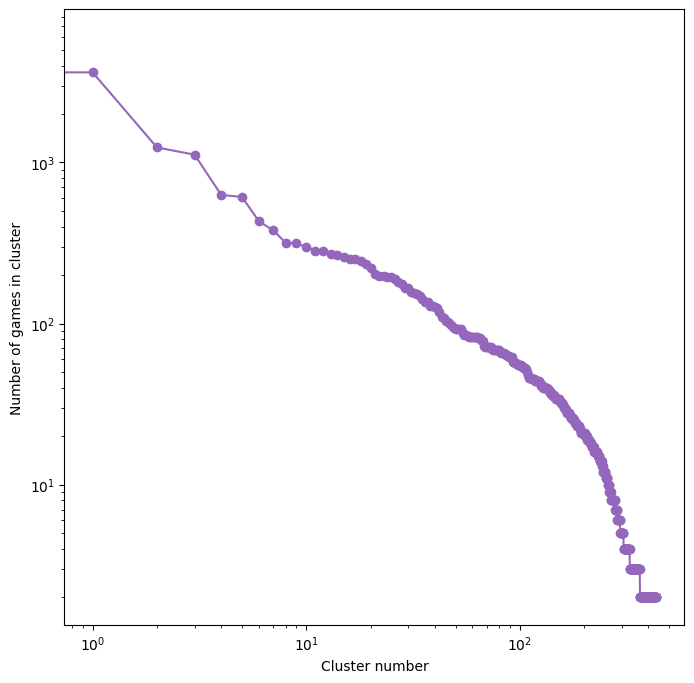

In [36]:
cluster_num, counts = list(zip(*sorted(Counter(infomap_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
fig, ax = plt.subplots(1, 1)
ax.loglog(cluster_num, counts, color='tab:purple', marker='o')
ax.set_xlabel("Cluster number")
ax.set_ylabel("Number of games in cluster")
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [37]:
cluster_nums = louvain_communities_df['community_num'].unique()
louvain = []
for cluster_num in cluster_nums:
    tmp_cluster = list(louvain_communities_df[(louvain_communities_df['community_num'] == cluster_num)]['id'])
    louvain.append(tmp_cluster)

cluster_nums = greedy_modularity_communities_df['community_num'].unique()
clauset_newman_moore = []
for cluster_num in cluster_nums:
    tmp_cluster = list(greedy_modularity_communities_df[(greedy_modularity_communities_df['community_num'] == cluster_num)]['id'])
    clauset_newman_moore.append(tmp_cluster)

cluster_nums = infomap_communities_df['community_num'].unique()
infomap = []
for cluster_num in cluster_nums:
    tmp_cluster = list(infomap_communities_df[(infomap_communities_df['community_num'] == cluster_num)]['id'])
    infomap.append(tmp_cluster)

In [38]:
algorithms = ['clauset_newman_moore', 'louvain', 'infomap']
modularity = [nx.community.modularity(filtered_graph, eval(algorithm)) for algorithm in algorithms]
coverage, performance = map(list, zip(*[nx.community.partition_quality(filtered_graph, eval(algorithm)) for algorithm in algorithms]))

In [ ]:
tmp_df = pd.DataFrame(columns=['modularity', 'coverage', 'performance'])
for index, name in enumerate(algorithms):
    tmp_df.loc[name] = [round(x, 3) for x in [modularity[index], coverage[index], performance[index]]]
tmp_df.loc['average'] = [round(tmp_df['modularity'].mean(), 3), round(tmp_df['coverage'].mean(), 3), round(tmp_df['performance'].mean(), 3)]
tmp_df

,modularity,coverage,performance
clauset_newman_moore,0.275,0.845,0.360
louvain,0.400,0.470,0.697
infomap,0.312,0.703,0.947
average,0.329,0.673,0.668


### User-Game Graph

In [17]:
def create_exploded_users_df(filename: str) -> pd.DataFrame:
    user_prefs_df = pd.read_csv(filename)
    user_prefs_df = user_prefs_df[(user_prefs_df['user_signup_date'].notna()) & (
        user_prefs_df['user_signup_date'] != "Null")]
    user_prefs_df['user_signup_date'] = pd.to_datetime(
        user_prefs_df['user_signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    user_prefs_df['user_signup_date'] = pd.to_datetime(
        user_prefs_df['user_signup_date'].dt.strftime('%Y-%m-%d'))
    user_prefs_df = user_prefs_df[(
        user_prefs_df['user_signup_date'] < '2023-01-01')]
    exploded_games_df = user_prefs_df.copy()
    exploded_games_df['user_games'] = exploded_games_df.copy()[
        'user_games'].str.split(',')
    exploded_games_df = exploded_games_df.explode('user_games').rename(
        columns={'user_games': 'game_id'})[['user_id', 'game_id']]
    return exploded_games_df


def create_bipartite_user_graph(df: pd.DataFrame) -> nx.Graph:
    bipartite_graph = nx.Graph()
    bipartite_graph.add_nodes_from(set(df['user_id'].values), bipartite=0)
    bipartite_graph.add_nodes_from(set(df['game_id'].values), bipartite=1)
    bipartite_graph.add_edges_from(
        [(user, game) for user, game in zip(df['user_id'], df['game_id'])])
    assert nx.is_bipartite(bipartite_graph)
    return bipartite_graph


def create_biadjacency_matrix(graph: nx.Graph) -> tuple[list[str], list[str], sparse.csr_matrix]:
    nodelist = list(graph.nodes(data='bipartite'))
    row_nodes = [node[0] for node in nodelist if node[1] == 0]
    col_nodes = [node[0] for node in nodelist if node[1] == 1]
    return row_nodes, col_nodes, sparse.csr_matrix(nx.bipartite.biadjacency_matrix(graph, row_order=row_nodes, column_order=col_nodes))

def create_community_user_betweenness_centrality_df(community_df: pd.DataFrame):
    games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv').rename(columns={'game_id': 'id'})
    user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv').rename(columns={'user_id': 'id'})
    bc_df = pd.read_csv('../data/processed/games/centrality/all_games_betweenness_centrality.csv')
    user_prefs_df['user_location'] = user_prefs_df['user_location'].str.upper()
    user_prefs_df.loc[user_prefs_df['user_location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'user_location'] = 'GB'
    user_prefs_df.loc[user_prefs_df['user_location'].isin(['CA', 'CA/QC']), 'user_location'] = 'CA'
    user_prefs_df.loc[user_prefs_df['user_location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'user_location'] = 'ES'
    user_merged_df = user_prefs_df.merge(community_df, on='id', how='inner')
    games_merged_df = games_metadata_df.merge(community_df, on='id', how='inner')
    games_merged_df = games_merged_df.merge(bc_df, on='id', how='inner')
    communities_df = user_merged_df.groupby('community_num').count().rename(columns={'id': 'num_users'}).reset_index()[['community_num', 'num_users']]
    communities_df = communities_df.merge(games_merged_df.groupby('community_num').count().rename(columns={'id': 'num_games'}).reset_index()[['community_num', 'num_games']], on='community_num', how='inner')
    communities_df['num_users_zscore'] = (communities_df['num_users'] - communities_df['num_users'].mean()) / communities_df['num_users'].std()
    communities_df['num_games_zscore'] = (communities_df['num_games'] - communities_df['num_games'].mean()) / communities_df['num_games'].std()
    communities_df['avg_num_games_played'] = communities_df['num_games'] / communities_df['num_users']
    return communities_df

def create_community_game_played_frequency_df(community_df: pd.DataFrame, num_community: int):
    games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv').rename(columns={'game_id': 'id'})
    user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv').rename(columns={'user_id': 'id'})
    bc_df = pd.read_csv('../data/processed/games/centrality/all_games_betweenness_centrality.csv')
    user_prefs_df['user_location'] = user_prefs_df['user_location'].str.upper()
    user_prefs_df.loc[user_prefs_df['user_location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'user_location'] = 'GB'
    user_prefs_df.loc[user_prefs_df['user_location'].isin(['CA', 'CA/QC']), 'user_location'] = 'CA'
    user_prefs_df.loc[user_prefs_df['user_location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'user_location'] = 'ES'
    user_merged_df = user_prefs_df.merge(community_df, on='id', how='inner')
    games_merged_df = games_metadata_df.merge(community_df, on='id', how='inner')
    games_merged_df = games_merged_df.merge(bc_df, on='id', how='inner')
    tmp_df = user_merged_df[user_merged_df['community_num'] == num_community].copy()
    tmp_df['user_games'] = tmp_df['user_games'].str.split(',')
    tmp_df = tmp_df.explode('user_games').rename(columns={'user_games': 'game_id'})
    tmp_df = tmp_df.groupby('game_id').count().reset_index().sort_values(by='user_num_games', ascending=False)
    games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
    tmp_df = tmp_df.merge(games_metadata_df, on='game_id', how='inner')
    return tmp_df, games_merged_df, user_merged_df

In [18]:
df = create_exploded_users_df("../data/raw/srcom_users_with_metadata.csv")
bipartite_graph = create_bipartite_user_graph(df)
components = sorted([component for component in nx.connected_components(bipartite_graph)], key=len, reverse=True)
sub_bipartite_graph = bipartite_graph.subgraph(components[0])
row_nodes, col_nodes, biadjacency_matrix = create_biadjacency_matrix(sub_bipartite_graph)

/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_5220/2572741445.py:33: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  return row_nodes, col_nodes, sparse.csr_matrix(nx.bipartite.biadjacency_matrix(graph, row_order=row_nodes, column_order=col_nodes))


In [19]:
print(f"Number of components in bipartite graph: {len(components)}")
print(f"Biggest component in bipartite graph: {len(max(components, key=len))}")
print(f"Number of nodes in the bipartite graph: {bipartite_graph.order()}")
print(f"Number of nodes in sub bipartite graph: {sub_bipartite_graph.order()}")
print(f"Percentage of nodes in the sub bipartite graph: {sub_bipartite_graph.order() / bipartite_graph.order():.2f}")
print(f"Same number of nodes in largest component and sub bipartite graph?: {sub_bipartite_graph.order() == len(max(components, key=len))}")
del bipartite_graph

Number of components in bipartite graph: 1039
Biggest component in bipartite graph: 364123
Number of nodes in the bipartite graph: 366747
Number of nodes in sub bipartite graph: 364123
Percentage of nodes in the sub bipartite graph: 0.99
Same number of nodes in largest component and sub bipartite graph?: True


In [21]:
community_df = pd.DataFrame()
generate = False
if generate:
    louvain = Louvain(modularity='newman')
    louvain.fit(biadjacency_matrix)
    all_labels = np.concatenate((louvain.labels_row_, louvain.labels_col_))
    all_nodes = np.concatenate((row_nodes, col_nodes))
    print(get_modularity(biadjacency_matrix,
          louvain.labels_row_, labels_col=louvain.labels_col_))
    community_df = pd.DataFrame({'id': all_nodes, 'community_num': all_labels})
else:
    community_df = pd.read_csv(
        '../data/processed/users/communities/sub_bipartite_bilouvain_communities.csv').set_index('index', inplace=False)
community_df

,id,community_num
index,,
0,xz9vrmn8,27
1,j4vrl5vj,66
2,8vo4np2x,17
3,7j4epvmx,25
4,y8d20olj,3
...,...,...
364118,k6q4l5md,12
364119,46wez36r,36
364120,9d3w9w1l,2


In [22]:
community_detection_performance_df = pd.read_csv('../data/processed/users/community_detection_performance.csv').set_index('algorithm')
community_detection_performance_df.round(3)

,modularity,performance,coverage
algorithm,,,
louvain,0.716,0.965,0.772
infomap,0.682,0.868,0.812
clauset_newman_moore,0.682,0.911,0.827


In [23]:
communities_df = create_community_user_betweenness_centrality_df(community_df)
communities_df.set_index('community_num').sort_values(by='num_users', ascending=False).head(20)

,num_users,num_games,num_users_zscore,num_games_zscore,avg_num_games_played
community_num,,,,,
0,30327,2362,7.380561,3.320839,0.077884
1,24432,4796,5.861476,6.980318,0.196300
2,20530,7388,4.855968,10.877348,0.359864
4,15247,134,3.494590,-0.028923,0.008789
3,14490,1562,3.299518,2.118052,0.107798
5,12509,738,2.789034,0.879181,0.058998
6,10721,237,2.328283,0.125936,0.022106
8,10003,89,2.143262,-0.096580,0.008897
7,9920,785,2.121873,0.949845,0.079133


In [25]:
num_community = 0

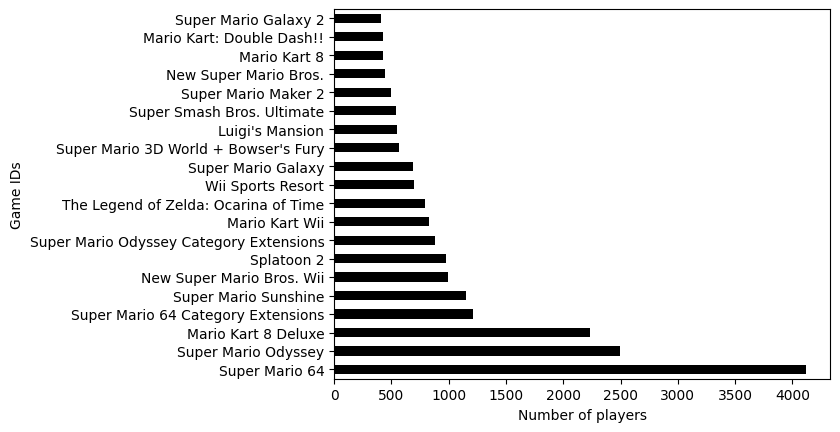

[['Super Mario 64', 4122],
 ['Super Mario Odyssey', 2492],
 ['Mario Kart 8 Deluxe', 2231],
 ['Super Mario 64 Category Extensions', 1213],
 ['Super Mario Sunshine', 1149],
 ['New Super Mario Bros. Wii', 994],
 ['Splatoon 2', 981],
 ['Super Mario Odyssey Category Extensions', 879],
 ['Mario Kart Wii', 832],
 ['The Legend of Zelda: Ocarina of Time', 796],
 ['Wii Sports Resort', 697],
 ['Super Mario Galaxy', 686],
 ["Super Mario 3D World + Bowser's Fury", 569],
 ["Luigi's Mansion", 547],
 ['Super Smash Bros. Ultimate', 540],
 ['Super Mario Maker 2', 494],
 ['New Super Mario Bros.', 449],
 ['Mario Kart 8', 428],
 ['Mario Kart: Double Dash!!', 425],
 ['Super Mario Galaxy 2', 413],
 ['Wii Sports', 383],
 ['Mario Kart 7', 344],
 ['New Super Mario Bros. U Deluxe', 343],
 ['Super Smash Bros. Melee', 322],
 ['New Super Mario Bros. 2', 314],
 ['Mario Kart 64', 314],
 ['Ocarina of Time Category Extensions', 307],
 ['Banjo-Kazooie', 295],
 ['Wii Party', 294],
 ['Mario Kart DS', 283],
 ['Kirby and th

In [26]:
games_played_df, games_info_df, user_info_df = create_community_game_played_frequency_df(community_df, num_community)
ax = games_played_df.head(20).plot.barh(x='game_name', y='user_num_games', color='black')
ax.set_xlabel("Number of players")
ax.set_ylabel("Game IDs")
ax.get_legend().remove()
plt.show()
games_played_df[(games_played_df['game_id'].isin(games_info_df[games_info_df['community_num']== num_community]['id'].values.tolist()))][['game_name', 'id']].values.tolist()

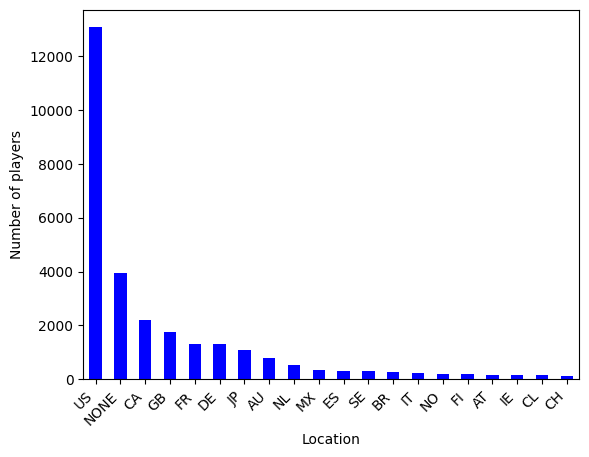

In [27]:
tmp_df = user_info_df[user_info_df['community_num']== num_community].copy()
tmp_df = tmp_df.groupby('user_location').count().reset_index(
).sort_values(by='user_num_games', ascending=False).head(20)
ax = tmp_df.plot.bar(x='user_location', y='user_num_games', color='blue')
ax.set_xlabel("Location")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("Number of players")
ax.get_legend().remove()
plt.show()

## Recommendation Systems

### Collaborative Filtering

In [28]:
def clean_user_preferences_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['user_signup_date'].notna()) & (df['user_signup_date'] != "Null")].copy()
    df['user_signup_date'] = pd.to_datetime(df['user_signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['user_signup_date'] = pd.to_datetime(df['user_signup_date'].dt.strftime('%Y-%m-%d'))
    df = df[(df['user_signup_date'] < '2023-01-01')]
    return df

def explode_games_played(df: pd.DataFrame) -> pd.DataFrame:
    df['user_games'] = df['user_games'].str.split(',')
    return df.explode('user_games').rename(columns = {'user_games': 'game_id'})

def recommendation_graph(df: pd.DataFrame) -> nx.Graph:
    df = clean_user_preferences_df(df)
    df = explode_games_played(df)
    bipartite_graph = nx.Graph()
    bipartite_graph.add_nodes_from(set(df['user_id'].values), bipartite=0)
    bipartite_graph.add_nodes_from(set(df['game_id'].values), bipartite=1)
    bipartite_graph.add_edges_from([(user, game) for user, game in zip(df['user_id'], df['game_id'])])
    return bipartite_graph

def user_similarity(bipartite_graph: nx.Graph, total_item_nodes: int, user_a_id: str, user_b_id: str) -> float:
    assert bipartite_graph.nodes[user_a_id]['bipartite'] == 0
    assert bipartite_graph.nodes[user_b_id]['bipartite'] == 0

    a_neighbours = bipartite_graph.neighbors(user_a_id)
    b_neighbours = bipartite_graph.neighbors(user_b_id)
    shared_nodes = set(a_neighbours).intersection(b_neighbours)

    return len(shared_nodes) / total_item_nodes

def most_similar_users(bipartite_graph: nx.Graph, user_id: str) -> tuple[list[str], float]:
    all_users = set([user for user, value in bipartite_graph.nodes(data=True) if value['bipartite'] == 0])
    all_users.remove(user_id)

    total_item_nodes = 0
    for _, values in bipartite_graph.nodes(data=True):
        if values['bipartite'] == 1: total_item_nodes += 1

    similarities = defaultdict(float)
    for user in all_users:
        similarities[user] = user_similarity(bipartite_graph, total_item_nodes, user_id, user)

    max_similarity = max(similarities.values())
    return [user for user, similarity in similarities.items() if similarity == max_similarity], max_similarity

def recommend_games(bipartite_graph: nx.Graph, user_id: str) -> list[str]:
    similar_users, _ = most_similar_users(bipartite_graph, user_id)
    other_games = [game for user in similar_users for game in bipartite_graph.neighbors(user)]
    game_rankings = Counter(other_games)

    already_played_games = set(bipartite_graph.neighbors(user_id))

    try:
        [game_rankings.pop(game) for game in already_played_games]
    except KeyError:
        # If no other users in data set have played this game.
        pass

    ranked_games_in_order, _ = list(zip(*sorted(game_rankings.items(), key=itemgetter(1), reverse=True)))
    
    return ranked_games_in_order

In [29]:
user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv')
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv').rename(columns={'game_id': 'id'})
bipartite_graph = recommendation_graph(user_prefs_df)

In [30]:
user = "x355n6qj"

played_games = list(bipartite_graph.neighbors(user))
print(f"Played games: {games_metadata_df[(games_metadata_df['id'].isin(played_games))].game_name.values}")

recommended_games = recommend_games(bipartite_graph, user)
print(f"Recommended games: {games_metadata_df.set_index('id').loc(axis=0)[recommended_games].game_name.values[:20]}")

Played games: ['Hello Neighbor' 'Super Mario Odyssey']
Recommended games: ['Hello Neighbor 2' 'Cuphead' 'Super Mario 64'
 "Five Nights at Freddy's: Security Breach" 'Poppy Playtime: Chapter 1'
 'Super Mario Bros.' 'Super Mario Bros. Category Extensions'
 'Minecraft: Java Edition' 'Super Mario Odyssey Category Extensions'
 "Baldi's Basics Category Extensions" 'Super Mario 64 (PC)' 'FNaF World'
 "Five Nights at Freddy's: Security Breach Category Extensions"
 'Logan Kart 8 Classic' 'Super Mario 63' 'The Glitched Attraction'
 'Super Mr. Krabs' 'Super Mario Bros.: The Lost Levels' 'Super Luigi Bros'
 'How To Rob A Gas Station']


### Content Filtering

In [32]:
def format_user_prefs_df_to_ratings(df: pd.DataFrame) -> pd.DataFrame:
    tmp_df = df.copy()
    tmp_df['user_games'] = tmp_df['user_games'].str.split(',')
    tmp_df = tmp_df.explode('user_games').rename(
        columns={'user_games': 'game_id', 'user': 'user_id'})
    tmp_df['rating'] = 1
    return tmp_df[['user_id', 'game_id', 'rating']]


def construct_similarity_matrix(df: pd.DataFrame) -> pd.DataFrame:
    tmp_df = df.copy()
    tmp_df = pd.pivot_table(tmp_df, values='rating',
                            index='user_id', columns='game_id')
    tmp_df = tmp_df.fillna(0.0)
    normalised_tmp_df = tmp_df / np.sqrt(np.square(tmp_df).sum(axis=0))
    return normalised_tmp_df.transpose().dot(normalised_tmp_df)


def recommend_from_game(similarity_matrix: pd.DataFrame, game_id: str, n_recommendations: int) -> list[str]:
    return similarity_matrix.nlargest(n_recommendations+1, game_id).index.values[1:]


def recommendation_metrics_at_k(test_df: pd.DataFrame, similarity_matrix: pd.DataFrame, k: int) -> tuple[float, float, float]:
    recommendations = []
    unique_games_in_test = np.unique(test_df['user_games'].str.split(
        ',').apply(pd.Series).stack().reset_index(drop=True))
    for game in unique_games_in_test:
        try:
            game_row = similarity_matrix.loc[game]
            recs = pd.Series(game_row).where(lambda x: x >= 0.1).dropna(
            ).sort_values(ascending=False).index.values.tolist()[1:k+1]
            recommendations.extend(recs)
        except KeyError:
            # If no other users in data set have played this game.
            pass

    relevant_games_set = set(unique_games_in_test)
    recommended_games_set = set(recommendations)
    intersection = len(recommended_games_set.intersection(relevant_games_set))
    recall = intersection/len(relevant_games_set)
    precision = intersection/len(recommended_games_set)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return recall, precision, f1_score

In [33]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv').rename(columns={'game_id': 'id'})
user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv').sort_values(by='user_num_games', ascending=False)[:4000]
train_df, test_df = train_test_split(user_prefs_df, test_size=0.2, random_state=0)
train_df = format_user_prefs_df_to_ratings(train_df)
similarity_matrix = construct_similarity_matrix(train_df)
print(f"Number of users in sample: {train_df['user_id'].nunique()}, Number of games in sample: {train_df['game_id'].nunique()}")

Number of users in sample: 3200, Number of games in sample: 22337


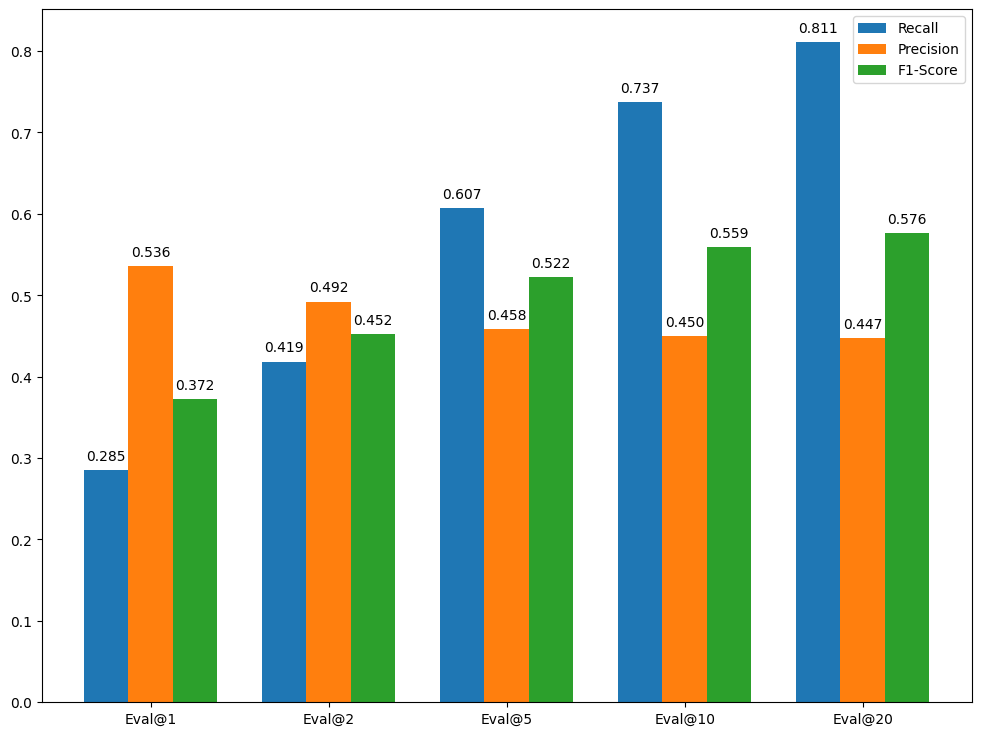

In [8]:
results_df = pd.DataFrame(columns=['Recall', 'Precision', 'F1-Score'])
for number_k in range(1, 21):
    recall, precision, f1_score = recommendation_metrics_at_k(
        test_df, similarity_matrix, number_k)
    results_df.loc[number_k] = recall, precision, f1_score

recall = results_df.loc[[1, 2, 5, 10, 20]]['Recall'].values.tolist()
precision = results_df.loc[[1, 2, 5, 10, 20]]['Precision'].values.tolist()
f1_score = results_df.loc[[1, 2, 5, 10, 20]]['F1-Score'].values.tolist()

labels = ['Eval@1', 'Eval@2', 'Eval@5', 'Eval@10', 'Eval@20']
width = 0.25
ind = np.arange(len(labels))

fig, ax = plt.subplots(1, 1)
ax.bar(ind - width, recall, width, label='Recall')
ax.bar(ind, precision, width, label='Precision')
ax.bar(ind + width,f1_score, width, label='F1-Score')
ax.legend(loc='best')
ax.set_xticks(ind, labels)

for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig.set_figheight(9)
fig.set_figwidth(12)

plt.show()

In [9]:
game_id = "4pd03wde"
n = 10
recommended_games = recommend_from_game(similarity_matrix, game_id, n)

print(f"Played Game: {games_metadata_df.set_index('id').loc(axis=0)[game_id].game_name}")
print(f"Recommended games: {games_metadata_df.set_index('id').loc(axis=0)[recommended_games].game_name.values}")

Played Game: World of Illusion Starring Mickey Mouse and Donald Duck
Recommended games: ['Castle of Illusion Starring Mickey Mouse (Genesis)'
 'Legend of Illusion starring Mickey Mouse'
 'The Great Circus Mystery Starring Mickey & Minnie (Genesis)'
 'TaleSpin (Genesis)' "Disney's Aladdin (Genesis)"
 'Castle of Illusion starring Mickey Mouse (SMS)' 'X-Men 2: Clone Wars'
 'Bonanza Bros. (Genesis)' 'ALF' 'QuackShot Starring Donald Duck']


In [10]:
game_id = "o1y9wo6q"
n = 10
recommended_games = recommend_from_game(similarity_matrix, game_id, n)

print(f"Played Game: {games_metadata_df.set_index('id').loc(axis=0)[game_id].game_name}")
print(f"Recommended games: {games_metadata_df.set_index('id').loc(axis=0)[recommended_games].game_name.values}")

Played Game: Super Mario 64
Recommended games: ['Super Mario 64 Category Extensions' 'Super Mario Sunshine'
 'Super Mario Odyssey' 'Super Mario Galaxy' 'Super Mario Galaxy 2'
 'Multiple Mario Games' 'Super Mario Star Road' 'SM64 Sapphire'
 'Super Mario 64 Online' 'Super Mario 64 Randomizer']
